# Compare slit profile with reference profile

## First try it out by hand for a single slit

In [1]:
from pathlib import Path
import yaml
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
from matplotlib import pyplot as plt
import seaborn as sns

import mes_longslit as mes


In [2]:
dpath = Path.cwd().parent / "data"
pvpath = dpath / "pvextract"
pvpath.mkdir(exist_ok=True)

List of data for each Ha slit exposure:

In [3]:
slit_db_list = yaml.safe_load(
    (dpath / "slits-ha.yml").read_text()
)

Photometric reference image:

In [4]:
photom, = fits.open(dpath / "regrid" / "ha-imslit-median.fits")
wphot = WCS(photom.header)

To start off with, we will analyze a single slit:

In [5]:
db = slit_db_list[-2]
db

{'slit_id': 'spm0440o',
 'orig_file': 'crspm0440o_b1t.fits',
 'image_id': 'spm0439o',
 'line_id': 'Ha',
 'slit_width': 150,
 'islit': 350,
 'trim': [0, 0, 0, -80],
 'bg_deg': 10,
 'bg_sig': 3,
 'jwin': [400, 510],
 'comment': 'Horizontal slit.'}

Get the HDUs for both the slit spectrum and the image+slit. The spectrum file names are very variable, so we have an `orig_file` entry in the database:

In [6]:
spec_hdu = fits.open(dpath / "originals" / db["orig_file"])[0]

But the image file names are more regular and can be derived from the `image_id` entry:

In [7]:
im_hdu, = fits.open(dpath / "wcs" / f"cr{db['image_id']}_b-wcs.fits")

There is no sign of any saturated pixels in any of the exposures, so we can miss out that step.

Add in extra fields to database:

- `wa` wavelength axis (1 or 2, fits order) in PV spectrum
- `ij` slit orientation in I+S (1=vertical, 2=horizontal)

In [8]:
if db["slit_id"].startswith("N"):
    db["wa"] = 2
    db["ij"] = 2
else:
    db["wa"] = 1
    db["ij"] = 1
db["s"] = 1

In [9]:
fill_value = np.nan # np.nanmedian(spec_hdu.data)

if "trim" in db:
    # Trim edges from array
    lx, ux, ly, uy = db["trim"]
    if ly > 0:
        spec_hdu.data[:ly, :] = fill_value
    if uy < 0:
        spec_hdu.data[uy:, :] = fill_value
    if lx > 0:
        spec_hdu.data[:, :lx] = fill_value
    if ux < 0:
        spec_hdu.data[:, ux:] = fill_value



#spec_hdu.data[-50:, :] = fill_value

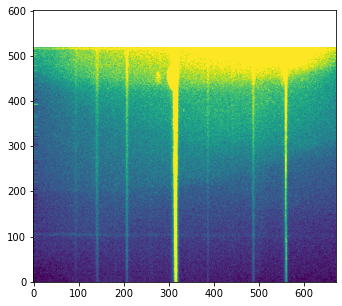

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
#ax.imshow(spec_hdu.data[250:700, :], 
#          #vmin=-3, vmax=30, 
#          origin="lower");
ax.imshow(spec_hdu.data[:, :],  vmin=-10, vmax=60, origin="lower");

Try to correct for gradient:

In [11]:
pvmed = np.nanmedian(spec_hdu.data, axis=1)
s = np.arange(len(pvmed))
pvmed0 = np.nanmedian(pvmed)
sig = np.nanstd(pvmed)
m = np.abs(pvmed - pvmed0) <= 5 * sig

/Users/will/miniconda3/envs/pn-ou5/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


In [12]:
from numpy.polynomial import Chebyshev

In [13]:
p = Chebyshev.fit(s[m], pvmed[m], 10)

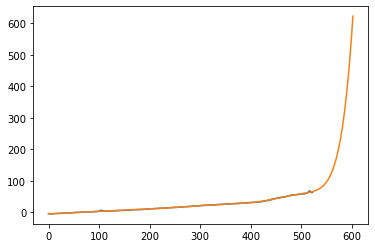

In [14]:
fig, ax = plt.subplots()
ax.plot(s[m], pvmed[m])
ax.plot(s, p(s))

In [15]:
spec_hdu.data -= p(s)[:, None]

In [16]:
fill_value = np.nanmedian(spec_hdu.data)

if "trim" in db:
    # Trim edges from array
    lx, ux, ly, uy = db["trim"]
    if ly > 0:
        spec_hdu.data[:ly, :] = fill_value
    if uy < 0:
        spec_hdu.data[uy:, :] = fill_value
    if lx > 0:
        spec_hdu.data[:, :lx] = fill_value
    if ux < 0:
        spec_hdu.data[:, ux:] = fill_value


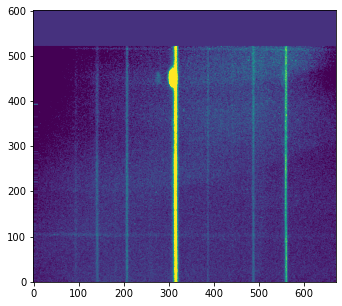

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(spec_hdu.data[:, :],  vmin=-10, vmax=60, origin="lower");

So that does a reasonably good job of subtracting the background emission line

Lines to avoid when calculating the continuum

In [18]:
restwavs = {'ha': 6562.79, 'heii': 6560.10, 'nii': 6583.45, 'nii_s': 6548.05}

In [19]:
spec_profile = mes.extract_full_profile_from_pv(
    spec_hdu,
    wavaxis=db["wa"],
    bandwidth=90.0,
    linedict=restwavs,
)

This is the position of the slit in pixel coordinates.

In [20]:
# islit values have now been added to the yaml database
# db["islit"] = 442

In [21]:
imslit_profile = mes.extract_slit_profile_from_imslit(
    im_hdu.data, db, slit_width=2,
)

350


In [22]:
jslit = np.arange(len(spec_profile))


In [23]:
spec_profile.shape, imslit_profile.shape

((603,), (603,))

In [24]:
spec_profile -= np.median(spec_profile)
imslit_profile -= np.median(imslit_profile)

### Find a better way to do the alignment

I am going to experiment with using cross-correlation to estimate the along-slit offset between `spec_profile` and `imslit_profile`:

In [25]:
ns = len(spec_profile)
assert len(imslit_profile) == ns, "Incompatible lengths"

The above assert would fail if the binning were different between the spectrum and the im+slit, which is something I will have to deal with later.

An array of pixel offsets that matches the result of `np.correlate` in "full" mode:

In [26]:
jshifts = np.arange( -(ns - 1), ns)

Now calculate the correlation:

In [27]:
xcorr = np.correlate(spec_profile, imslit_profile, mode="full")

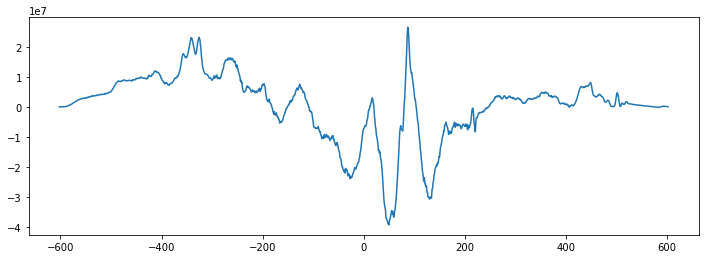

In [28]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(jshifts, xcorr)
#ax.set(xlim=[-300, 300]);

Wow, that is a very clean result! One large peak, at an offset of roughly 100, exactly where we expect it to be.

Check different measures of where the peak is. First, a simple weighted average in a broad window:

In [29]:
from astropy.table import Table

In [30]:
window_sizes = [200, 250, 300, 350, 400]
jshift_means = []
for window_size in window_sizes:
    m = np.abs(jshifts) < window_size
    jshift_means.append(np.average(jshifts[m], weights=xcorr[m]))
Table({"size": window_sizes, "jshift": jshift_means})

size,jshift
int64,float64
200,49.66878939357551
250,81.63963270323372
300,152.69609861379658
350,348.4280485862481
400,668.5600679784945


No, that is no good: it depends heavily on the window chosen.  Try just taking the peak value:

In [31]:
mm = (np.abs(jshifts) < 110) & (np.abs(jshifts) > 50)
jshift_peak = jshifts[mm][xcorr[mm].argmax()]
jshift_peak

87

That is much better, at least for this example.

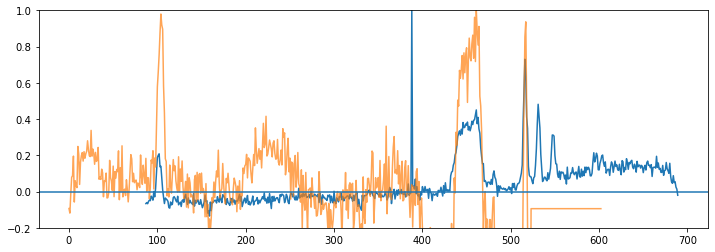

In [32]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(jslit + jshift_peak, imslit_profile / np.max(imslit_profile))
ax.plot(jslit, spec_profile / np.max(spec_profile), alpha=0.7)
ax.set(yscale="linear", ylim=[-0.2, 1])
ax.axhline(0);


In [33]:
jwin_slice = slice(*db["jwin"])
jwin_slice_shift = slice(
    jwin_slice.start - jshift_peak, 
    jwin_slice.stop - jshift_peak,
)

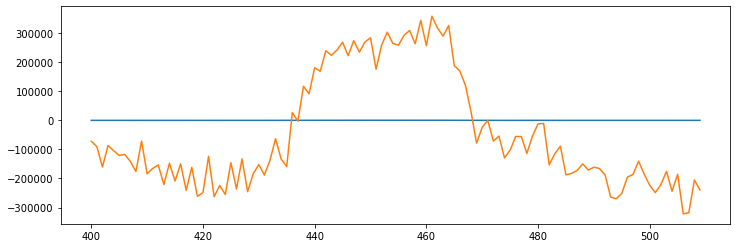

In [34]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(jslit[jwin_slice], imslit_profile[jwin_slice_shift])
ax.plot(jslit[jwin_slice], 100 * spec_profile[jwin_slice])
ax.set(
    yscale="linear", 
#    ylim=[0, 1000]
);



We need to find the alignment along the slit.  Just use the initial guess for now.

In [35]:
j0_s = np.average(jslit[jwin_slice], weights=spec_profile[jwin_slice])
j0_i = np.average(jslit[jwin_slice_shift], weights=(10 + imslit_profile[jwin_slice_shift]))
db["shift"] = jshift_peak
j0_s, j0_i, db["shift"]

(464.4410451604173, 368.4104125940628, 87)

In [36]:
slit_coords = mes.find_slit_coords(db, im_hdu.header, spec_hdu.header)

iarr = [349. 349. 349. 349. 349. 349. 349.] jarr = [-87.  13. 113. 213. 313. 413. 513.]
coords = <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(318.49268432, 43.68747687), (318.51281234, 43.68877397),
     (318.53294124, 43.69006754), (318.55307102, 43.69135757),
     (318.57320166, 43.69264408), (318.59333317, 43.69392705),
     (318.61346553, 43.69520648)]>
Binning along slit: image = 3 spectrum = 3


In [37]:
slit_coords['Dec'].shape, jslit.shape

((603,), (603,))

In [38]:
calib_profile = mes.slit_profile(
    slit_coords['RA'], 
    slit_coords['Dec'],
    photom.data, 
    wphot,
    #r = slit_coords["ds"],
)

Plot the calibration profile (green) compared with the spec and imslit profiles:

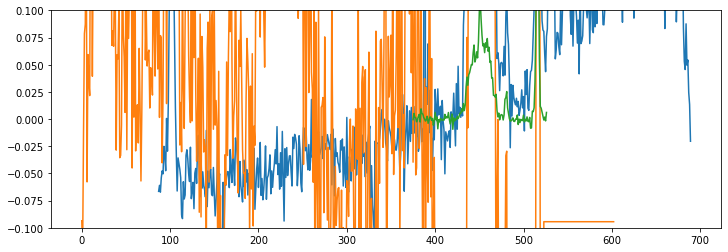

In [39]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(jslit + db["shift"], imslit_profile / imslit_profile.max())
ax.plot(jslit, spec_profile / spec_profile.max())
ax.plot(jslit, 0.05 * calib_profile)
ax.set(yscale="linear", ylim=[-0.1, 0.1]);

This is now working fine after I fixed the pixel scale in the calibration image. 

We have the ability to look at the profiles at neighboring slit positions in the calibration image. This allows us to see if we might have an error in the `islit` value:

In [40]:
neighbors = [-2, -1, 1, 2]
nb_calib_profiles = {}
for nb in neighbors:
    nbdb = db.copy()
    nbdb["islit"] += nb
    nb_slit_coords = mes.find_slit_coords(nbdb, im_hdu.header, spec_hdu.header)
    nb_calib_profiles[nb] = mes.slit_profile(
        nb_slit_coords['RA'], 
        nb_slit_coords['Dec'], 
        photom.data, 
        wphot, 
        #nb_slit_coords["ds"],
    )

iarr = [347. 347. 347. 347. 347. 347. 347.] jarr = [-87.  13. 113. 213. 313. 413. 513.]


coords = <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(318.49272024, 43.68718578), (318.51284817, 43.68848287),
     (318.53297697, 43.68977643), (318.55310665, 43.69106646),
     (318.57323719, 43.69235296), (318.59336861, 43.69363592),
     (318.61350088, 43.69491535)]>
Binning along slit: image = 3 spectrum = 3
iarr = [348. 348. 348. 348. 348. 348. 348.] jarr = [-87.  13. 113. 213. 313. 413. 513.]
coords = <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(318.49270228, 43.68733133), (318.51283025, 43.68862842),
     (318.53295911, 43.68992199), (318.55308883, 43.69121202),
     (318.57321943, 43.69249852), (318.59335089, 43.69378148),
     (318.6134832 , 43.69506092)]>
Binning along slit: image = 3 spectrum = 3
iarr = [350. 350. 350. 350. 350. 350. 350.] jarr = [-87.  13. 113. 213. 313. 413. 513.]
coords = <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(318.49266636, 43.68762242), (318.51279443, 43.68891952),
     (318.53292338, 43.69021309), (318.5530532 , 4

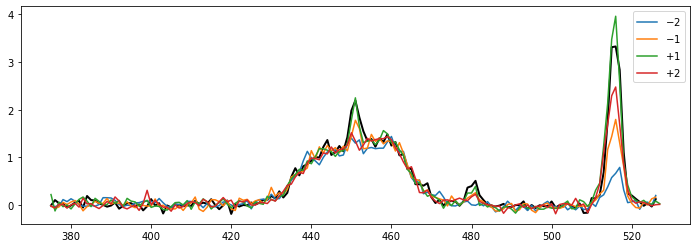

In [41]:
fig, ax = plt.subplots(figsize=(12, 4))
# ax.plot(jslit + db["shift"], (imslit_profile + 20) * 10)
# ax.plot(jslit, spec_profile)
ax.plot(jslit, calib_profile, color="k", lw=2)
for nb in neighbors:
    ax.plot(jslit, nb_calib_profiles[nb], label=f"${nb:+d}$")
ax.legend()
ax.set(yscale="linear");

In [42]:
slit_points = (np.arange(len(spec_profile)) - j0_s)*slit_coords["ds"]

In [43]:
jslice0 = slice(int(j0_s)-20, int(j0_s)+20)

In [44]:
rat0 = np.nansum(spec_profile[jslice0]) / np.nansum(calib_profile[jslice0])
print('Coarse calibration: ratio =', rat0)

Coarse calibration: ratio = 1601.0124900122444


In [45]:
spec_profile[jslice0]

array([ 2.4214397e+03,  2.6909526e+03,  2.2261450e+03,  2.7436440e+03,
        2.3495786e+03,  2.6943604e+03,  2.8432756e+03,  1.7629230e+03,
        2.5950408e+03,  3.0354441e+03,  2.6504526e+03,  2.5853540e+03,
        2.9245833e+03,  3.0939180e+03,  2.6372712e+03,  3.4469536e+03,
        2.5715896e+03,  3.5838723e+03,  3.1801445e+03,  2.8991951e+03,
        3.2660164e+03,  1.8859579e+03,  1.6957013e+03,  1.2061007e+03,
        2.9555215e+02, -7.8433875e+02, -2.4054105e+02, -1.5025940e+00,
       -7.1520068e+02, -5.4145288e+02, -1.2907076e+03, -1.0274429e+03,
       -5.5384290e+02, -5.5587500e+02, -1.1391741e+03, -5.3862402e+02,
       -1.2070450e+02, -1.0587894e+02, -1.5285658e+03, -1.1509010e+03],
      dtype=float32)

In [46]:
calib_profile[jslice0]

array([ 1.36253545,  1.04980579,  1.11098991,  1.23740666,  1.12573403,
        1.4225775 ,  1.97883872,  2.19376696,  1.83644536,  1.54677499,
        1.34674124,  1.38463125,  1.22251294,  1.40240862,  1.32219248,
        1.48201298,  1.24688698,  1.32126982,  1.04183664,  1.06564308,
        0.75394995,  0.75929472,  0.43603448,  0.43434958,  0.40413197,
        0.45605814,  0.16087486,  0.04082996,  0.11008625, -0.01366537,
        0.06794823,  0.08299286,  0.07190432, -0.01651002,  0.07633524,
        0.3639351 ,  0.39607392,  0.50632866,  0.2050382 ,  0.1012471 ])

In [47]:
spec_profile /= rat0

In [48]:
figpath = Path.cwd().parent / "figs"
figpath.mkdir(exist_ok=True)

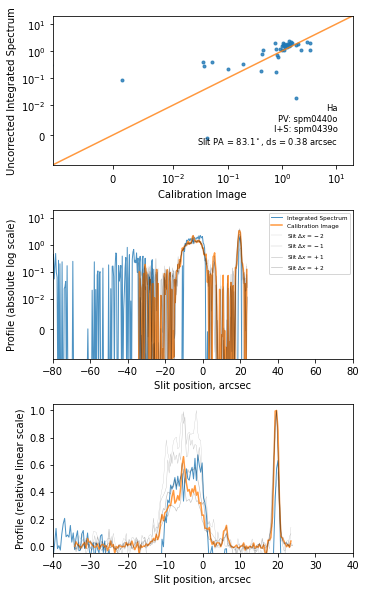

In [49]:
plt_prefix = figpath / f"{db['slit_id']}-calib"
mes.make_three_plots(
    spec_profile, 
    calib_profile, 
    plt_prefix,
    slit_points=slit_points,
    neighbors=nb_calib_profiles,
    db=db, 
    sdb=slit_coords,
    return_fig=True,
);

This is what the database is looking like now:

In [50]:
db

{'slit_id': 'spm0440o',
 'orig_file': 'crspm0440o_b1t.fits',
 'image_id': 'spm0439o',
 'line_id': 'Ha',
 'slit_width': 150,
 'islit': 350,
 'trim': [0, 0, 0, -80],
 'bg_deg': 10,
 'bg_sig': 3,
 'jwin': [400, 510],
 'comment': 'Horizontal slit.',
 'wa': 1,
 'ij': 1,
 's': 1,
 'shift': 87}

In [51]:
restwavs

{'ha': 6562.79, 'heii': 6560.1, 'nii': 6583.45, 'nii_s': 6548.05}

### Write out the flux-calibrated spectra

In [52]:
# spec_hdu.data /= rat0
# # The default header has minimal changes from the original
# pvheader = fits.Header(spec_hdu.header, copy=True)
# 

In [53]:
# for lineid, wav0 in restwavs.items():
#     pvdata, contdata, wavs = mes.extract_line_and_regularize(
#         spec_hdu.data, WCS(spec_hdu.header), wav0, db)
#     pvdata = pvdata[None, :, :]
#     contdata = contdata[None, :, :]
# 
#     # Create a fancy WCS object for slit coordinates (and a simple one too)
#     wslit, wsimp = mes.make_slit_wcs(db, slit_coords, wavs, j0_s)
#     # Set the rest wavelength for this line
#     wslit.wcs.restwav = (wav0*u.Angstrom).to(u.m).value
#     pvheader.update(wsimp.to_header())
#     pvheader.update(wslit.to_header(key='A'))
#     pvheader['WEIGHT'] = rat0
# 
#     pvfile = str(pvpath / f"{db['slit_id']}-{lineid}.fits")
#     pvcfile = pvfile.replace(".fits", "-cont.fits")
#     fits.PrimaryHDU(
#         header=pvheader,
#         data=pvdata
#     ).writeto(pvfile, overwrite=True)
# 
#     fits.PrimaryHDU(
#         header=pvheader,
#         data=contdata
#     ).writeto(pvcfile, overwrite=True)
# 

## Now try the automated way

In [54]:
for db in slit_db_list:
    print(db)
    spec_hdu = fits.open(dpath / "originals" / db["orig_file"])[0]
    im_hdu, = fits.open(dpath / "wcs" / f"cr{db['image_id']}_b-wcs.fits")
    if db["slit_id"].startswith("N"):
        db["wa"] = 2
        db["ij"] = 2
    else:
        db["wa"] = 1
        db["ij"] = 1
    db["s"] = 1
    
    mes.pv_extract(
        spec_hdu,
        im_hdu,
        photom,
        db,
        restwavs,
        pvpath,
        neighbors=[-1, 1],
    )

{'slit_id': 'N10036', 'orig_file': 'crN10036_bx.fits', 'image_id': 'N10035', 'line_id': 'Ha', 'slit_width': 70, 'islit': 442, 'jwin': [400, 600], 'comment': 'Just E of center.'}
442
Shift along slit: 104
iarr = [-104.   -4.   96.  196.  296.  396.  496.  596.  696.  796.] jarr = [441. 441. 441. 441. 441. 441. 441. 441. 441. 441.]
coords = <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(318.58462218, 43.64536921), (318.58456887, 43.65510626),
     (318.58451554, 43.66484331), (318.58446219, 43.67458037),
     (318.58440883, 43.68431742), (318.58435545, 43.69405447),
     (318.58430205, 43.70379152), (318.58424863, 43.71352857),
     (318.5841952 , 43.72326562), (318.58414175, 43.73300267)]>
Binning along slit: image = 2 spectrum = 2
iarr = [-104.   -4.   96.  196.  296.  396.  496.  596.  696.  796.] jarr = [440. 440. 440. 440. 440. 440. 440. 440. 440. 440.]
coords = <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(318.58475674, 43.6453696 ), (318.58470345, 43.65510665),


Wav: [6557.79, 6559.29] Pixel: [281.24183879 308.68275109]
Wav: [6566.29, 6567.79] Pixel: [436.74034187 464.18125417]
Background weights: 27944 26946
Wav: [6557.79, 6567.79] Pixel: [281.24183879 464.18125417]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58461346, 43.64536366), (318.5845601 , 43.65510071),
     (318.58450673, 43.66483776), (318.58445334, 43.6745748 ),
     (318.58439993, 43.68431185), (318.58434651, 43.69404889),
     (318.58429306, 43.70378593), (318.58423961, 43.71352296),
     (318.58418613, 43.72326   ), (318.58413263, 43.73299702)]>
Displacements in arcsec: [0.         0.00011235 0.00022517 0.00033892 0.00045405 0.00057102
 0.00069025 0.00081218 0.00093721 0.00106572]
Wav: [6555.1, 6556.6] Pixel: [232.03113605 259.47204836]
Wav: [6563.6, 6565.1] Pixel: [387.52963913 414.97055143]
Background weights: 26946 26946
Wav: [6555.1, 6565.1] Pixel: [232.03113605 414.97055143]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58461346, 43.64536366), (318.5

Wav: [6578.45, 6579.95] Pixel: [659.19467098 686.63558329]
Wav: [6586.95, 6588.45] Pixel: [814.69317406 842.13408637]
Background weights: 27944 26946
Wav: [6578.45, 6588.45] Pixel: [659.19467098 842.13408637]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58461346, 43.64536366), (318.5845601 , 43.65510071),
     (318.58450673, 43.66483776), (318.58445334, 43.6745748 ),
     (318.58439993, 43.68431185), (318.58434651, 43.69404889),
     (318.58429306, 43.70378593), (318.58423961, 43.71352296),
     (318.58418613, 43.72326   ), (318.58413263, 43.73299702)]>
Displacements in arcsec: [0.         0.00011235 0.00022517 0.00033892 0.00045405 0.00057102
 0.00069025 0.00081218 0.00093721 0.00106572]
Wav: [6543.05, 6544.55] Pixel: [11.5891405  39.03005281]
Wav: [6551.55, 6553.05] Pixel: [167.08764358 194.52855589]
Background weights: 26946 27944
Wav: [6543.05, 6553.05] Pixel: [ 11.5891405  194.52855589]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58461346, 43.64536366), (3

Wav: [6557.79, 6559.29] Pixel: [280.26977061 307.68986388]
Wav: [6566.29, 6567.79] Pixel: [435.65029918 463.07039245]
Background weights: 27944 26946
Wav: [6557.79, 6567.79] Pixel: [280.26977061 463.07039245]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58550406, 43.64509074), (318.58545716, 43.6548297 ),
     (318.58541023, 43.66456866), (318.58536329, 43.67430762),
     (318.58531633, 43.68404658), (318.58526936, 43.69378553),
     (318.58522238, 43.70352449), (318.58517538, 43.71326344),
     (318.58512836, 43.72300238), (318.58508133, 43.73274132)]>
Displacements in arcsec: [0.00000000e+00 9.88214021e-05 1.98178958e-04 2.98607007e-04
 4.00629780e-04 5.04757656e-04 6.11483688e-04 7.21279476e-04
 8.34593706e-04 9.51849332e-04]
Wav: [6555.1, 6556.6] Pixel: [231.09640333 258.51649661]
Wav: [6563.6, 6565.1] Pixel: [386.4769319  413.89702518]
Background weights: 27944 27944
Wav: [6555.1, 6565.1] Pixel: [231.09640333 413.89702518]
New coords: <SkyCoord (ICRS): (ra, dec) in deg

Wav: [6578.45, 6579.95] Pixel: [657.93585534 685.35594862]
Wav: [6586.95, 6588.45] Pixel: [813.31638392 840.73647719]
Background weights: 26946 27944
Wav: [6578.45, 6588.45] Pixel: [657.93585534 840.73647719]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58550406, 43.64509074), (318.58545716, 43.6548297 ),
     (318.58541023, 43.66456866), (318.58536329, 43.67430762),
     (318.58531633, 43.68404658), (318.58526936, 43.69378553),
     (318.58522238, 43.70352449), (318.58517538, 43.71326344),
     (318.58512836, 43.72300238), (318.58508133, 43.73274132)]>
Displacements in arcsec: [0.00000000e+00 9.88214021e-05 1.98178958e-04 2.98607007e-04
 4.00629780e-04 5.04757656e-04 6.11483688e-04 7.21279476e-04
 8.34593706e-04 9.51849332e-04]
Wav: [6543.05, 6544.55] Pixel: [10.821654   38.24174728]
Wav: [6551.55, 6553.05] Pixel: [166.20218257 193.62227585]
Background weights: 26946 27944
Wav: [6543.05, 6553.05] Pixel: [ 10.821654   193.62227585]
New coords: <SkyCoord (ICRS): (ra, dec) in

Wav: [6557.79, 6559.29] Pixel: [263.66533191 291.55535776]
Wav: [6566.29, 6567.79] Pixel: [421.70881175 449.5988376 ]
Background weights: 27944 27944
Wav: [6557.79, 6567.79] Pixel: [263.66533191 449.5988376 ]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58555259, 43.62955663), (318.58549863, 43.63929856),
     (318.58544465, 43.64904049), (318.58539065, 43.65878241),
     (318.58533663, 43.66852434), (318.58528259, 43.67826626),
     (318.58522854, 43.68800818), (318.58517447, 43.6977501 ),
     (318.58512038, 43.70749202), (318.58506628, 43.71723393)]>
Displacements in arcsec: [0.         0.00011372 0.00022825 0.00034439 0.00046294 0.00058466
 0.00071027 0.00084045 0.00097586 0.00111708]
Wav: [6555.1, 6556.6] Pixel: [213.64921888 241.53924473]
Wav: [6563.6, 6565.1] Pixel: [371.69269872 399.58272457]
Background weights: 27944 27944
Wav: [6555.1, 6565.1] Pixel: [213.64921888 399.58272457]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58555259, 43.62955663), (318.5

Wav: [6578.45, 6579.95] Pixel: [647.80395467 675.69398052]
Wav: [6586.95, 6588.45] Pixel: [805.8474345  833.73746035]
Background weights: 27944 27944
Wav: [6578.45, 6588.45] Pixel: [647.80395467 833.73746035]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58555259, 43.62955663), (318.58549863, 43.63929856),
     (318.58544465, 43.64904049), (318.58539065, 43.65878241),
     (318.58533663, 43.66852434), (318.58528259, 43.67826626),
     (318.58522854, 43.68800818), (318.58517447, 43.6977501 ),
     (318.58512038, 43.70749202), (318.58506628, 43.71723393)]>
Displacements in arcsec: [0.         0.00011372 0.00022825 0.00034439 0.00046294 0.00058466
 0.00071027 0.00084045 0.00097586 0.00111708]


Wav: [6543.05, 6544.55] Pixel: [-10.40065547  17.48937038]
Wav: [6551.55, 6553.05] Pixel: [147.64282436 175.53285021]
Background weights: 16966 27944
Wav: [6543.05, 6553.05] Pixel: [-10.40065547 175.53285021]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58555259, 43.62955663), (318.58549863, 43.63929856),
     (318.58544465, 43.64904049), (318.58539065, 43.65878241),
     (318.58533663, 43.66852434), (318.58528259, 43.67826626),
     (318.58522854, 43.68800818), (318.58517447, 43.6977501 ),
     (318.58512038, 43.70749202), (318.58506628, 43.71723393)]>
Displacements in arcsec: [0.         0.00011372 0.00022825 0.00034439 0.00046294 0.00058466
 0.00071027 0.00084045 0.00097586 0.00111708]
{'slit_id': 'N20012', 'orig_file': 'crN20012_bx.fits', 'image_id': 'N20011', 'line_id': 'Ha', 'slit_width': 70, 'islit': 439, 'jwin': [580, 740], 'trim': [0, 0, 0, -50], 'shift_range': [50, 110], 'comment': 'W of center.'}
439
Shift along slit: 97
iarr = [-97.   3. 103. 203. 303. 403. 503.

Wav: [6557.79, 6559.29] Pixel: [283.35848473 310.31081533]
Wav: [6566.29, 6567.79] Pixel: [436.08835811 463.04068871]
Background weights: 26946 26946
Wav: [6557.79, 6567.79] Pixel: [283.35848473 463.04068871]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58366801, 43.62830226), (318.58361508, 43.63804839),
     (318.58356214, 43.64779452), (318.58350919, 43.65754065),
     (318.58345621, 43.66728678), (318.58340322, 43.6770329 ),
     (318.58335021, 43.68677902), (318.58329719, 43.69652514),
     (318.58324414, 43.70627126), (318.58319108, 43.71601737)]>
Displacements in arcsec: [0.         0.0001116  0.00022418 0.00033874 0.0004562  0.0005775
 0.00070349 0.00083497 0.00097269 0.00111732]
Wav: [6555.1, 6556.6] Pixel: [235.02397186 261.97630246]
Wav: [6563.6, 6565.1] Pixel: [387.75384524 414.70617584]
Background weights: 26946 26946
Wav: [6555.1, 6565.1] Pixel: [235.02397186 414.70617584]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58366801, 43.62830226), (318.58

Wav: [6578.45, 6579.95] Pixel: [654.58191815 681.53424875]
Wav: [6586.95, 6588.45] Pixel: [807.31179153 834.26412213]
Background weights: 26946 26946
Wav: [6578.45, 6588.45] Pixel: [654.58191815 834.26412213]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58366801, 43.62830226), (318.58361508, 43.63804839),
     (318.58356214, 43.64779452), (318.58350919, 43.65754065),
     (318.58345621, 43.66728678), (318.58340322, 43.6770329 ),
     (318.58335021, 43.68677902), (318.58329719, 43.69652514),
     (318.58324414, 43.70627126), (318.58319108, 43.71601737)]>
Displacements in arcsec: [0.         0.0001116  0.00022418 0.00033874 0.0004562  0.0005775
 0.00070349 0.00083497 0.00097269 0.00111732]
Wav: [6543.05, 6544.55] Pixel: [18.50691607 45.45924666]
Wav: [6551.55, 6553.05] Pixel: [171.23678945 198.18912005]
Background weights: 25948 26946
Wav: [6543.05, 6553.05] Pixel: [ 18.50691607 198.18912005]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58366801, 43.62830226), (31

Wav: [6557.79, 6559.29] Pixel: [207.88450713 226.04163947]
Wav: [6566.29, 6567.79] Pixel: [310.7749237  328.93205603]
Background weights: 11826 11826
Wav: [6557.79, 6567.79] Pixel: [207.88450713 328.93205603]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58552443, 43.62350099), (318.58575126, 43.63812374),
     (318.58597819, 43.65274648), (318.58620524, 43.66736922),
     (318.5864324 , 43.68199195), (318.58665967, 43.69661467),
     (318.58688705, 43.71123738)]>
Displacements in arcsec: [0.         0.00047142 0.00094418 0.00141963 0.00189909 0.00238388
 0.00287529]
Wav: [6555.1, 6556.6] Pixel: [175.32271648 193.47984881]
Wav: [6563.6, 6565.1] Pixel: [278.21313304 296.37026538]
Background weights: 11826 11826
Wav: [6555.1, 6565.1] Pixel: [175.32271648 296.37026538]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58552443, 43.62350099), (318.58575126, 43.63812374),
     (318.58597819, 43.65274648), (318.58620524, 43.66736922),
     (318.5864324 , 43.68199195), (318.

Wav: [6557.79, 6559.29] Pixel: [217.09660224 234.90018436]
Wav: [6566.29, 6567.79] Pixel: [317.98356761 335.78714973]
Background weights: 11790 11790
Wav: [6557.79, 6567.79] Pixel: [217.09660224 335.78714973]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58352429, 43.64731883), (318.58370991, 43.66193107),
     (318.58389561, 43.67654332), (318.58408141, 43.69115555),
     (318.5842673 , 43.70576779), (318.58445327, 43.72038001),
     (318.58463934, 43.73499222)]>
Displacements in arcsec: [0.         0.00038439 0.00076941 0.00115568 0.00154382 0.00193446
 0.0023282 ]
Wav: [6555.1, 6556.6] Pixel: [185.16884496 202.97242709]
Wav: [6563.6, 6565.1] Pixel: [286.05581033 303.85939246]
Background weights: 11790 11790
Wav: [6555.1, 6565.1] Pixel: [185.16884496 303.85939246]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58352429, 43.64731883), (318.58370991, 43.66193107),
     (318.58389561, 43.67654332), (318.58408141, 43.69115555),
     (318.5842673 , 43.70576779), (318.

Wav: [6557.79, 6559.29] Pixel: [217.12759229 234.93086426]
Wav: [6566.29, 6567.79] Pixel: [318.01280014 335.81607211]
Background weights: 11790 11790
Wav: [6557.79, 6567.79] Pixel: [217.12759229 335.81607211]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58250179, 43.64681252), (318.5827018 , 43.66142637),
     (318.5829019 , 43.67604022), (318.5831021 , 43.69065407),
     (318.5833024 , 43.70526792), (318.5835028 , 43.71988175),
     (318.5837033 , 43.73449558)]>
Displacements in arcsec: [0.         0.00041423 0.00082906 0.00124508 0.00166289 0.00208308
 0.00250623]
Wav: [6555.1, 6556.6] Pixel: [185.20039121 203.00366319]
Wav: [6563.6, 6565.1] Pixel: [286.08559906 303.88887104]
Background weights: 11790 11790
Wav: [6555.1, 6565.1] Pixel: [185.20039121 303.88887104]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58250179, 43.64681252), (318.5827018 , 43.66142637),
     (318.5829019 , 43.67604022), (318.5831021 , 43.69065407),
     (318.5833024 , 43.70526792), (318.

Wav: [6557.79, 6559.29] Pixel: [217.58035893 235.38843393]
Wav: [6566.29, 6567.79] Pixel: [318.49278396 336.30085897]
Background weights: 11135 11790
Wav: [6557.79, 6567.79] Pixel: [217.58035893 336.30085897]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58130055, 43.6390881 ), (318.58154554, 43.65371016),
     (318.58179065, 43.66833221), (318.58203588, 43.68295426),
     (318.58228122, 43.6975763 ), (318.58252669, 43.71219833),
     (318.58277227, 43.72682035)]>
Displacements in arcsec: [0.         0.00050761 0.00101592 0.00152564 0.00203746 0.00255209
 0.0030702 ]
Wav: [6555.1, 6556.6] Pixel: [185.64454442 203.45261942]
Wav: [6563.6, 6565.1] Pixel: [286.55696945 304.36504446]
Background weights: 11135 11135
Wav: [6555.1, 6565.1] Pixel: [185.64454442 304.36504446]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58130055, 43.6390881 ), (318.58154554, 43.65371016),
     (318.58179065, 43.66833221), (318.58203588, 43.68295426),
     (318.58228122, 43.6975763 ), (318.

/Users/will/miniconda3/envs/pn-ou5/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


336
Shift along slit: 95
iarr = [335. 335. 335. 335. 335. 335. 335.] jarr = [-95.   5. 105. 205. 305. 405. 505.]
coords = <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(318.58236036, 43.64815778), (318.58267389, 43.66276662),
     (318.58298758, 43.67737546), (318.58330142, 43.69198431),
     (318.58361541, 43.70659315), (318.58392955, 43.72120199),
     (318.58424385, 43.73581083)]>
Binning along slit: image = 3 spectrum = 3
iarr = [334. 334. 334. 334. 334. 334. 334.] jarr = [-95.   5. 105. 205. 305. 405. 505.]
coords = <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(318.58256225, 43.64815551), (318.58287583, 43.66276435),
     (318.58318957, 43.67737319), (318.58350346, 43.69198204),
     (318.5838175 , 43.70659088), (318.58413169, 43.72119972),
     (318.58444604, 43.73580855)]>
Binning along slit: image = 3 spectrum = 3
iarr = [336. 336. 336. 336. 336. 336. 336.] jarr = [-95.   5. 105. 205. 305. 405. 505.]
coords = <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg


Wav: [6557.79, 6559.29] Pixel: [255.66813089 273.37997274]
Wav: [6566.29, 6567.79] Pixel: [356.03523471 373.74707656]
Background weights: 10251 10854
Wav: [6557.79, 6567.79] Pixel: [255.66813089 373.74707656]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58235164, 43.64815222), (318.5826654 , 43.66276106),
     (318.58297931, 43.6773699 ), (318.58329338, 43.69197873),
     (318.5836076 , 43.70658755), (318.58392198, 43.72119637),
     (318.5842365 , 43.73580517)]>
Displacements in arcsec: [0.         0.00059781 0.00119601 0.00179498 0.00239511 0.00299677
 0.00360037]
Wav: [6555.1, 6556.6] Pixel: [223.9048945  241.61673635]
Wav: [6563.6, 6565.1] Pixel: [324.27199832 341.98384017]
Background weights: 10854 10854
Wav: [6555.1, 6565.1] Pixel: [223.9048945  341.98384017]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58235164, 43.64815222), (318.5826654 , 43.66276106),
     (318.58297931, 43.6773699 ), (318.58329338, 43.69197873),
     (318.5836076 , 43.70658755), (318.

/Users/will/miniconda3/envs/pn-ou5/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


Wav: [6543.05, 6544.55] Pixel: [81.61976497 99.33160682]
Wav: [6551.55, 6553.05] Pixel: [181.98686879 199.69871064]
Background weights: 10251 10854
Wav: [6543.05, 6553.05] Pixel: [ 81.61976497 199.69871064]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58235164, 43.64815222), (318.5826654 , 43.66276106),
     (318.58297931, 43.6773699 ), (318.58329338, 43.69197873),
     (318.5836076 , 43.70658755), (318.58392198, 43.72119637),
     (318.5842365 , 43.73580517)]>
Displacements in arcsec: [0.         0.00059781 0.00119601 0.00179498 0.00239511 0.00299677
 0.00360037]
{'slit_id': 'spm0215o', 'orig_file': 'crspm0215o_b1t.fits', 'image_id': 'spm0214o', 'line_id': 'Ha', 'slit_width': 150, 'islit': 339, 'trim': [0, 0, 0, -200], 'shift_range': [50, 110], 'jwin': [250, 360], 'comment': 'Crosses W limb.'}
339
Shift along slit: 99
iarr = [338. 338. 338. 338. 338. 338. 338.] jarr = [-99.   1. 101. 201. 301. 401. 501.]
coords = <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(318.

Wav: [6557.79, 6559.29] Pixel: [254.19116566 271.90575194]
Wav: [6566.29, 6567.79] Pixel: [354.57382128 372.28840756]
Background weights: 10854 10251
Wav: [6557.79, 6567.79] Pixel: [254.19116566 372.28840756]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58048024, 43.64802624), (318.5807929 , 43.66263243),
     (318.58110572, 43.67723863), (318.58141868, 43.69184482),
     (318.5817318 , 43.706451  ), (318.58204507, 43.72105717),
     (318.5823585 , 43.73566333)]>
Displacements in arcsec: [0.         0.00059561 0.0011916  0.00178838 0.00238633 0.00298583
 0.00358728]
Wav: [6555.1, 6556.6] Pixel: [222.42300758 240.13759387]
Wav: [6563.6, 6565.1] Pixel: [322.8056632  340.52024949]
Background weights: 10854 10854
Wav: [6555.1, 6565.1] Pixel: [222.42300758 340.52024949]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58048024, 43.64802624), (318.5807929 , 43.66263243),
     (318.58110572, 43.67723863), (318.58141868, 43.69184482),
     (318.5817318 , 43.706451  ), (318.

/Users/will/miniconda3/envs/pn-ou5/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


Wav: [6557.79, 6559.29] Pixel: [261.19203339 278.89960833]
Wav: [6566.29, 6567.79] Pixel: [361.53495804 379.24253298]
Background weights: 10854 10251
Wav: [6557.79, 6567.79] Pixel: [261.19203339 379.24253298]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58380313, 43.64619391), (318.5840785 , 43.66080771),
     (318.58435401, 43.6754215 ), (318.58462965, 43.69003528),
     (318.58490543, 43.70464906), (318.58518134, 43.71926284),
     (318.58545738, 43.7338766 )]>
Displacements in arcsec: [0.         0.00052484 0.00105016 0.00157646 0.00210422 0.00263391
 0.00316604]
Wav: [6555.1, 6556.6] Pixel: [229.436449   247.14402394]
Wav: [6563.6, 6565.1] Pixel: [329.77937366 347.48694859]
Background weights: 10854 10251
Wav: [6555.1, 6565.1] Pixel: [229.436449   347.48694859]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.58380313, 43.64619391), (318.5840785 , 43.66080771),
     (318.58435401, 43.6754215 ), (318.58462965, 43.69003528),
     (318.58490543, 43.70464906), (318.

/Users/will/miniconda3/envs/pn-ou5/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


Wav: [6557.79, 6559.29] Pixel: [257.24914702 274.96464831]
Wav: [6566.29, 6567.79] Pixel: [357.63698764 375.35248893]
Background weights: 10854 10251
Wav: [6557.79, 6567.79] Pixel: [257.24914702 375.35248893]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.49267561, 43.68747132), (318.51280492, 43.6887578 ),
     (318.53293509, 43.69004075), (318.55306612, 43.69132017),
     (318.573198  , 43.69259606), (318.59333072, 43.69386841),
     (318.61346429, 43.69513722)]>
Displacements in arcsec: [0.         0.03836211 0.07672424 0.11508641 0.15344863 0.19181091
 0.23017327]
Wav: [6555.1, 6556.6] Pixel: [225.47934805 243.19484933]
Wav: [6563.6, 6565.1] Pixel: [325.86718867 343.58268996]
Background weights: 10854 10854
Wav: [6555.1, 6565.1] Pixel: [225.47934805 343.58268996]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.49267561, 43.68747132), (318.51280492, 43.6887578 ),
     (318.53293509, 43.69004075), (318.55306612, 43.69132017),
     (318.573198  , 43.69259606), (318.

/Users/will/miniconda3/envs/pn-ou5/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


Background weights: 10854 10251
Wav: [6543.05, 6553.05] Pixel: [ 83.16482105 201.26816296]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.49267561, 43.68747132), (318.51280492, 43.6887578 ),
     (318.53293509, 43.69004075), (318.55306612, 43.69132017),
     (318.573198  , 43.69259606), (318.59333072, 43.69386841),
     (318.61346429, 43.69513722)]>
Displacements in arcsec: [0.         0.03836211 0.07672424 0.11508641 0.15344863 0.19181091
 0.23017327]
{'slit_id': 'spm0601o', 'orig_file': 'crspm0601o_b1t.fits', 'image_id': 'spm0600o', 'line_id': 'Ha', 'slit_width': 150, 'islit': 339, 'trim': [0, 0, 0, -150], 'jwin': [320, 430], 'comment': 'Crosses W limb.'}
339
Shift along slit: 100
iarr = [338. 338. 338. 338. 338. 338. 338.] jarr = [-100.    0.  100.  200.  300.  400.  500.]
coords = <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(318.57989827, 43.63925541), (318.58020907, 43.65387255),
     (318.58052003, 43.6684897 ), (318.58083114, 43.68310685),
     (318.5811424 

Wav: [6557.79, 6559.29] Pixel: [258.82989671 276.54189126]
Wav: [6566.29, 6567.79] Pixel: [359.19786586 376.90986042]
Background weights: 10854 10854
Wav: [6557.79, 6567.79] Pixel: [258.82989671 376.90986042]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.57988955, 43.63924986), (318.58020058, 43.653867  ),
     (318.58051176, 43.66848413), (318.5808231 , 43.68310126),
     (318.58113459, 43.69771838), (318.58144623, 43.7123355 ),
     (318.58175802, 43.7269526 )]>
Displacements in arcsec: [0.         0.00059289 0.00118637 0.00178104 0.00237751 0.00297636
 0.00357819]
Wav: [6555.1, 6556.6] Pixel: [227.06638647 244.77838102]
Wav: [6563.6, 6565.1] Pixel: [327.43435562 345.14635018]
Background weights: 10854 10854
Wav: [6555.1, 6565.1] Pixel: [227.06638647 345.14635018]
New coords: <SkyCoord (ICRS): (ra, dec) in deg
    [(318.57988955, 43.63924986), (318.58020058, 43.653867  ),
     (318.58051176, 43.66848413), (318.5808231 , 43.68310126),
     (318.58113459, 43.69771838), (318.

In [55]:
db

{'slit_id': 'spm0601o',
 'orig_file': 'crspm0601o_b1t.fits',
 'image_id': 'spm0600o',
 'line_id': 'Ha',
 'slit_width': 150,
 'islit': 339,
 'trim': [0, 0, 0, -150],
 'jwin': [320, 430],
 'comment': 'Crosses W limb.',
 'wa': 1,
 'ij': 1,
 's': 1,
 'shift': 100}